In [ ]:
# Find the floor plane which the aruco on the cart travels around in
# So that the deprojection from the image to the position is constrained and accurate

# Make a 50cm square on the floor in camera view.  
# Position the cart at all four corners with the 0 corner of the aruco
# above the each corner of the square.  Work clockwise

In [2]:
# This uses the known cameraMatrix and distCoeffs.  
# Marker length is of the aruco tag
import numpy as np
import cv2

# Alex webcam
imageSize = (640, 480)
cameraMatrix = np.\
array([[978.05105325,   0.        , 256.92932715],
       [  0.        , 978.05105325, 275.31236529],
       [  0.        ,   0.        ,   1.        ]])
distCoeffs = np.array([[-5.94459890e+00,  8.09059356e+01,  8.26388143e-03, -7.75808134e-03,  4.71557836e+01]])

markerLength = 0.080  # dimension in metres
winSize, zeroZone, criteria = (5, 5), (-1, -1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)

aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)


parameters =  cv2.aruco.DetectorParameters_create()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_CONTOUR


48 [array([[[143.6907 , 340.50412],
        [146.37051, 299.81644],
        [195.1222 , 298.57004],
        [194.23236, 339.0875 ]]], dtype=float32)]
49 None
49 None
49 None
49 None
49 [array([[[156.25555 ,  89.33394 ],
        [159.80968 ,  63.0211  ],
        [197.16446 ,  62.654514],
        [195.55205 ,  89.97023 ]]], dtype=float32)]
50 [array([[[447.7694  ,  83.2726  ],
        [443.59692 ,  56.89374 ],
        [482.05075 ,  57.506245],
        [486.90387 ,  84.50399 ]]], dtype=float32)]
51 [array([[[490.92316, 335.27026],
        [480.62827, 294.62354],
        [528.6594 , 292.11685],
        [540.46094, 332.87872]]], dtype=float32)]


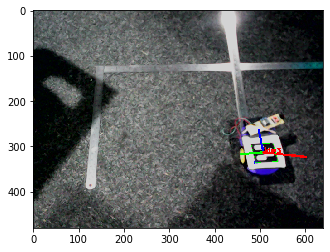

In [9]:
# Collect corners of the aruco tag at corners of the floor square

floorsquarelength = 0.50

import time

arucocartkey = "aruco3"
cap = cv2.VideoCapture(2)  # works on webcam plugged in
cap.set(cv2.CAP_PROP_SHARPNESS, 1)
cap.set(cv2.CAP_PROP_BRIGHTNESS, 80)

arucocartcornersSquare = [None,None,None,None]
while True:
    if not cap.grab():
        time.sleep(0.01)
        continue
    ret, frame = cap.retrieve()
    
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(frame, aruco_dict, parameters=parameters)
    gframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    for corner in corners:
        cv2.cornerSubPix(gframe, corner, winSize, zeroZone, criteria)
    crvecs, ctvecs, _objPoints = cv2.aruco.estimatePoseSingleMarkers(corners, markerLength, cameraMatrix, distCoeffs)
    bframe = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    arucocartcorners = None
    if ids is not None:
        for i in range(len(ids)):
            cv2.aruco.drawAxis(bframe, cameraMatrix, distCoeffs, crvecs[i], ctvecs[i], 0.1)
            key = "aruco%d"%ids[i][0]
            if key == arucocartkey:
                arucocartcorners = corners
    cv2.aruco.drawDetectedMarkers(bframe, corners, ids)
    cv2.imshow('frame', bframe)
    k = cv2.waitKey(1) & 0xFF
    if k == ord('q'):
        break
    if ord('0') <= k <= ord('3'):
        arucocartcornersSquare[k-ord('0')] = arucocartcorners
        print(chr(k), arucocartcorners)

cap.release()
cv2.destroyAllWindows()
        
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(bframe)


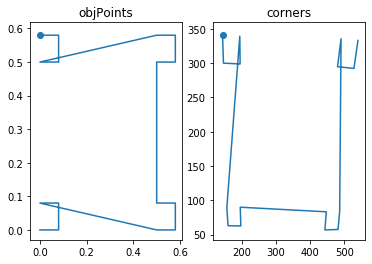

In [68]:
# produce the corresponding 16 points (square of squares)
def posmarkercorners(x, y, markerLength):
    return [[x, y + markerLength, 0], 
            [x + markerLength, y + markerLength, 0],
            [x + markerLength, y, 0],
            [x, y, 0]]

objPoints = posmarkercorners(0, floorsquarelength, markerLength) + \
            posmarkercorners(floorsquarelength, floorsquarelength, markerLength) + \
            posmarkercorners(floorsquarelength, 0, markerLength) + \
            posmarkercorners(0, 0, markerLength)

# reflection correction?
#objPoints = [ [X[0], -X[1], X[2]]  for X in objPoints ]  

corners = np.concatenate([arucocartcornersSquare[0][0][0], 
                          arucocartcornersSquare[1][0][0],
                          arucocartcornersSquare[2][0][0],
                          arucocartcornersSquare[3][0][0]])

plt.subplot(121)
plt.plot([X[0]  for X in objPoints], [X[1]  for X in objPoints])
plt.scatter([objPoints[0][0]], [objPoints[0][1]])
plt.title("objPoints")
plt.subplot(122)
plt.plot([X[0]  for X in corners], [X[1]  for X in corners])
plt.scatter([corners[0][0]], [corners[0][1]])
plt.title("corners");


In [69]:
#cv2.aruco.drawAxis(bframe, cameraMatrix, distCoeffs, crvecs[i], ctvecs[i], 0.1)
retval, rvec, tvec = cv2.solvePnP(np.array(objPoints), corners, cameraMatrix, distCoeffs)
assert retval
rvec, tvec


(array([[ 1.9095011 ],
        [-1.9463084 ],
        [ 0.73197729]]), array([[0.4150638 ],
        [0.09830259],
        [1.46671931]]))

[0.4150638  0.09830259 1.46671931]
[-0.05775419 -0.82797921  0.55777672]
[-0.99033931 -0.02303593 -0.13673844]
[ 0.1260655  -0.56028543 -0.81864994] -1.2034819631309672
(Not a great matchup)


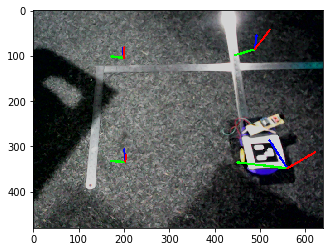

In [121]:
# Solve the Perspective n point calculation to find the plane everything lies in
retval, rvec, tvec = cv2.solvePnP(np.array(objPoints), corners, cameraMatrix, distCoeffs)
assert retval
rvec, tvec

bframe = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
m = cv2.Rodrigues(rvec)[0]

plane0 = tvec.T[0]
planeX = m.T[0]
planeY = m.T[1]
planeZ = m.T[2]
dot0Z = sum(plane0*planeZ)

tvec0 = plane0
tvec1 = plane0 + planeX*floorsquarelength
tvec2 = plane0 + planeX*floorsquarelength + planeY*floorsquarelength
tvec3 = plane0 + planeY*floorsquarelength

cv2.aruco.drawAxis(bframe, cameraMatrix, distCoeffs, rvec, tvec0, 0.1)
cv2.aruco.drawAxis(bframe, cameraMatrix, distCoeffs, rvec, tvec1, 0.05)
cv2.aruco.drawAxis(bframe, cameraMatrix, distCoeffs, rvec, tvec2, 0.05)
cv2.aruco.drawAxis(bframe, cameraMatrix, distCoeffs, rvec, tvec3, 0.05)
plt.imshow(bframe)
print(plane0)
print(planeX)
print(planeY)
print(planeZ, dot0Z)
print("(Not a great matchup)")

Text(0.5, 1.0, 'planecorners')

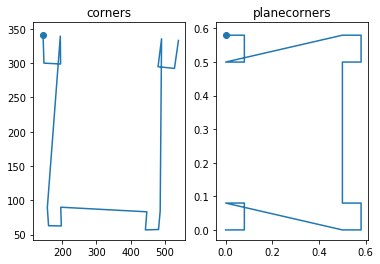

In [131]:
def projecttofloorplane(iu, iv):
    cu, cv = cv2.undistortPoints(np.array([iu, iv]), cameraMatrix, distCoeffs)[0][0]
    # Solve (cu*k, cv*k, k) . planeZ = dot0Z 
    k = dot0Z / sum(planeZ*np.array([cu, cv, 1]))
    p = np.array([cu*k, cv*k, k])
    pu = sum((p - plane0)*planeX)
    pv = sum((p - plane0)*planeY)
    return pu, pv

#iu, iv = corners[0][0], corners[0][1]
#pu, pv = projecttofloorplane(iu, iv)

planecorners = [ projecttofloorplane(iu, iv)  for iu, iv in corners ]

plt.subplot(121)
plt.plot([X[0]  for X in corners], [X[1]  for X in corners])
plt.scatter([corners[0][0]], [corners[0][1]])
plt.title("corners");
plt.subplot(122)
plt.plot([X[0]  for X in objPoints], [X[1]  for X in objPoints])
plt.scatter([objPoints[0][0]], [objPoints[0][1]])
plt.title("planecorners")



In [137]:
print("plane0 = np.%s" % repr(plane0))
print("planeX = np.%s" % repr(planeX))
print("planeY = np.%s" % repr(planeY))
print("planeZ = np.%s" % repr(planeZ))

plane0 = np.array([0.4150638 , 0.09830259, 1.46671931])
planeX = np.array([-0.05775419, -0.82797921,  0.55777672])
planeY = np.array([-0.99033931, -0.02303593, -0.13673844])
planeZ = np.array([ 0.1260655 , -0.56028543, -0.81864994])


In [140]:
cap.release()